# Imports and Paths

In [4]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import xarray as xr
import datetime as ddt
from run_params import *
import itertools

In [5]:
from palettable.cartocolors.qualitative import Prism_8
prism = Prism_8.mpl_colors

blue = prism[1]
green = prism[3]
purple = prism[0]
red = prism[7]
orange = prism[6]
yellow = prism[5]
gray = '#303039'

char = 'abcdefghijklmnopqrstuvwxyz'

from palettable.cmocean.diverging import Balance_20
bal = Balance_20.mpl_colormap
from palettable.scientific.sequential import Devon_14
from palettable.cmocean.sequential import Ice_6_r
from palettable.cmocean.sequential import Matter_11
from palettable.cmocean.sequential import Gray_6_r

cloud = Gray_6_r.mpl_colors[1:]
rain = Ice_6_r.mpl_colors[1:]
ccn = Matter_11.mpl_colors

#conden = Devon_14.mpl_colormap
conden = Devon_14.mpl_colormap
conden.set_bad(Devon_14.mpl_colors[0])

In [6]:
import sys

style = '/home/gleung/scripts/styles/bee-paperlight.mplstyle'
lcol = 'black'
bg = 'white'#'#303039'

def add_legend(ax):
    leg = ax.legend()
    for h, text in zip(leg.legendHandles, leg.get_texts()):
        try:
            text.set_color(h.get_facecolor()[0])
        except:
            text.set_color(h.get_color())

        
plt.style.use(style)

import matplotlib.font_manager as font_manager
from matplotlib import rcParams

# Add every font at the specified location
font_dir = ['/home/gleung/scripts/futura']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Set font family globally
rcParams['font.family'] = 'Futura'

In [7]:
nz = 120

dataPath = "/squall/gleung/aerobudget/absc.100/"
p = 'a-A-2019-09-16-000000-g1.h5'

def read_zs(dataPath, p, nz):
    save = False
    c = 0
    alts = []

    with open(f"{dataPath}/{p.split('/')[-1].split('.')[0][:-2]}head.txt") as f:
        lines = f.readlines()
        for line in lines:
            if '__ztn' in line:
                save = True
                c = -2

            if save:
                if c>=0:
                    alts.append(float(line))
                c +=1

            if (c>nz-1):
                save=False
    
    alts = pd.Series(alts)
    alts.index.name = 'z'
    return(alts)

alt = (read_zs(dataPath, p, nz))

In [9]:
anaPath = f"/squall/gleung/aerobudget-analysis/"
figPath = f"{anaPath}../aerobudget-figures/paper/"

if not os.path.isdir(figPath):
    os.mkdir(figPath)

cs = ['#e2ab44','#ce614f','#cf5490','#8035ac']
dates = [dt.datetime(year=2019,month=9,day=16,hour=0) + 
         dt.timedelta(minutes=5*i) for i in range(577)]

concs = [100,500,1000,1500]

labels = pd.DataFrame(
            ['Absorbing Carbon','Ammonium Sulphate','Sea Salt','Mineral Dust'],
                      index=['absc','sulf','salt','dust'],
    columns = ['Name']
                     )


# Fig 2. Domain-wide aerosol budgets

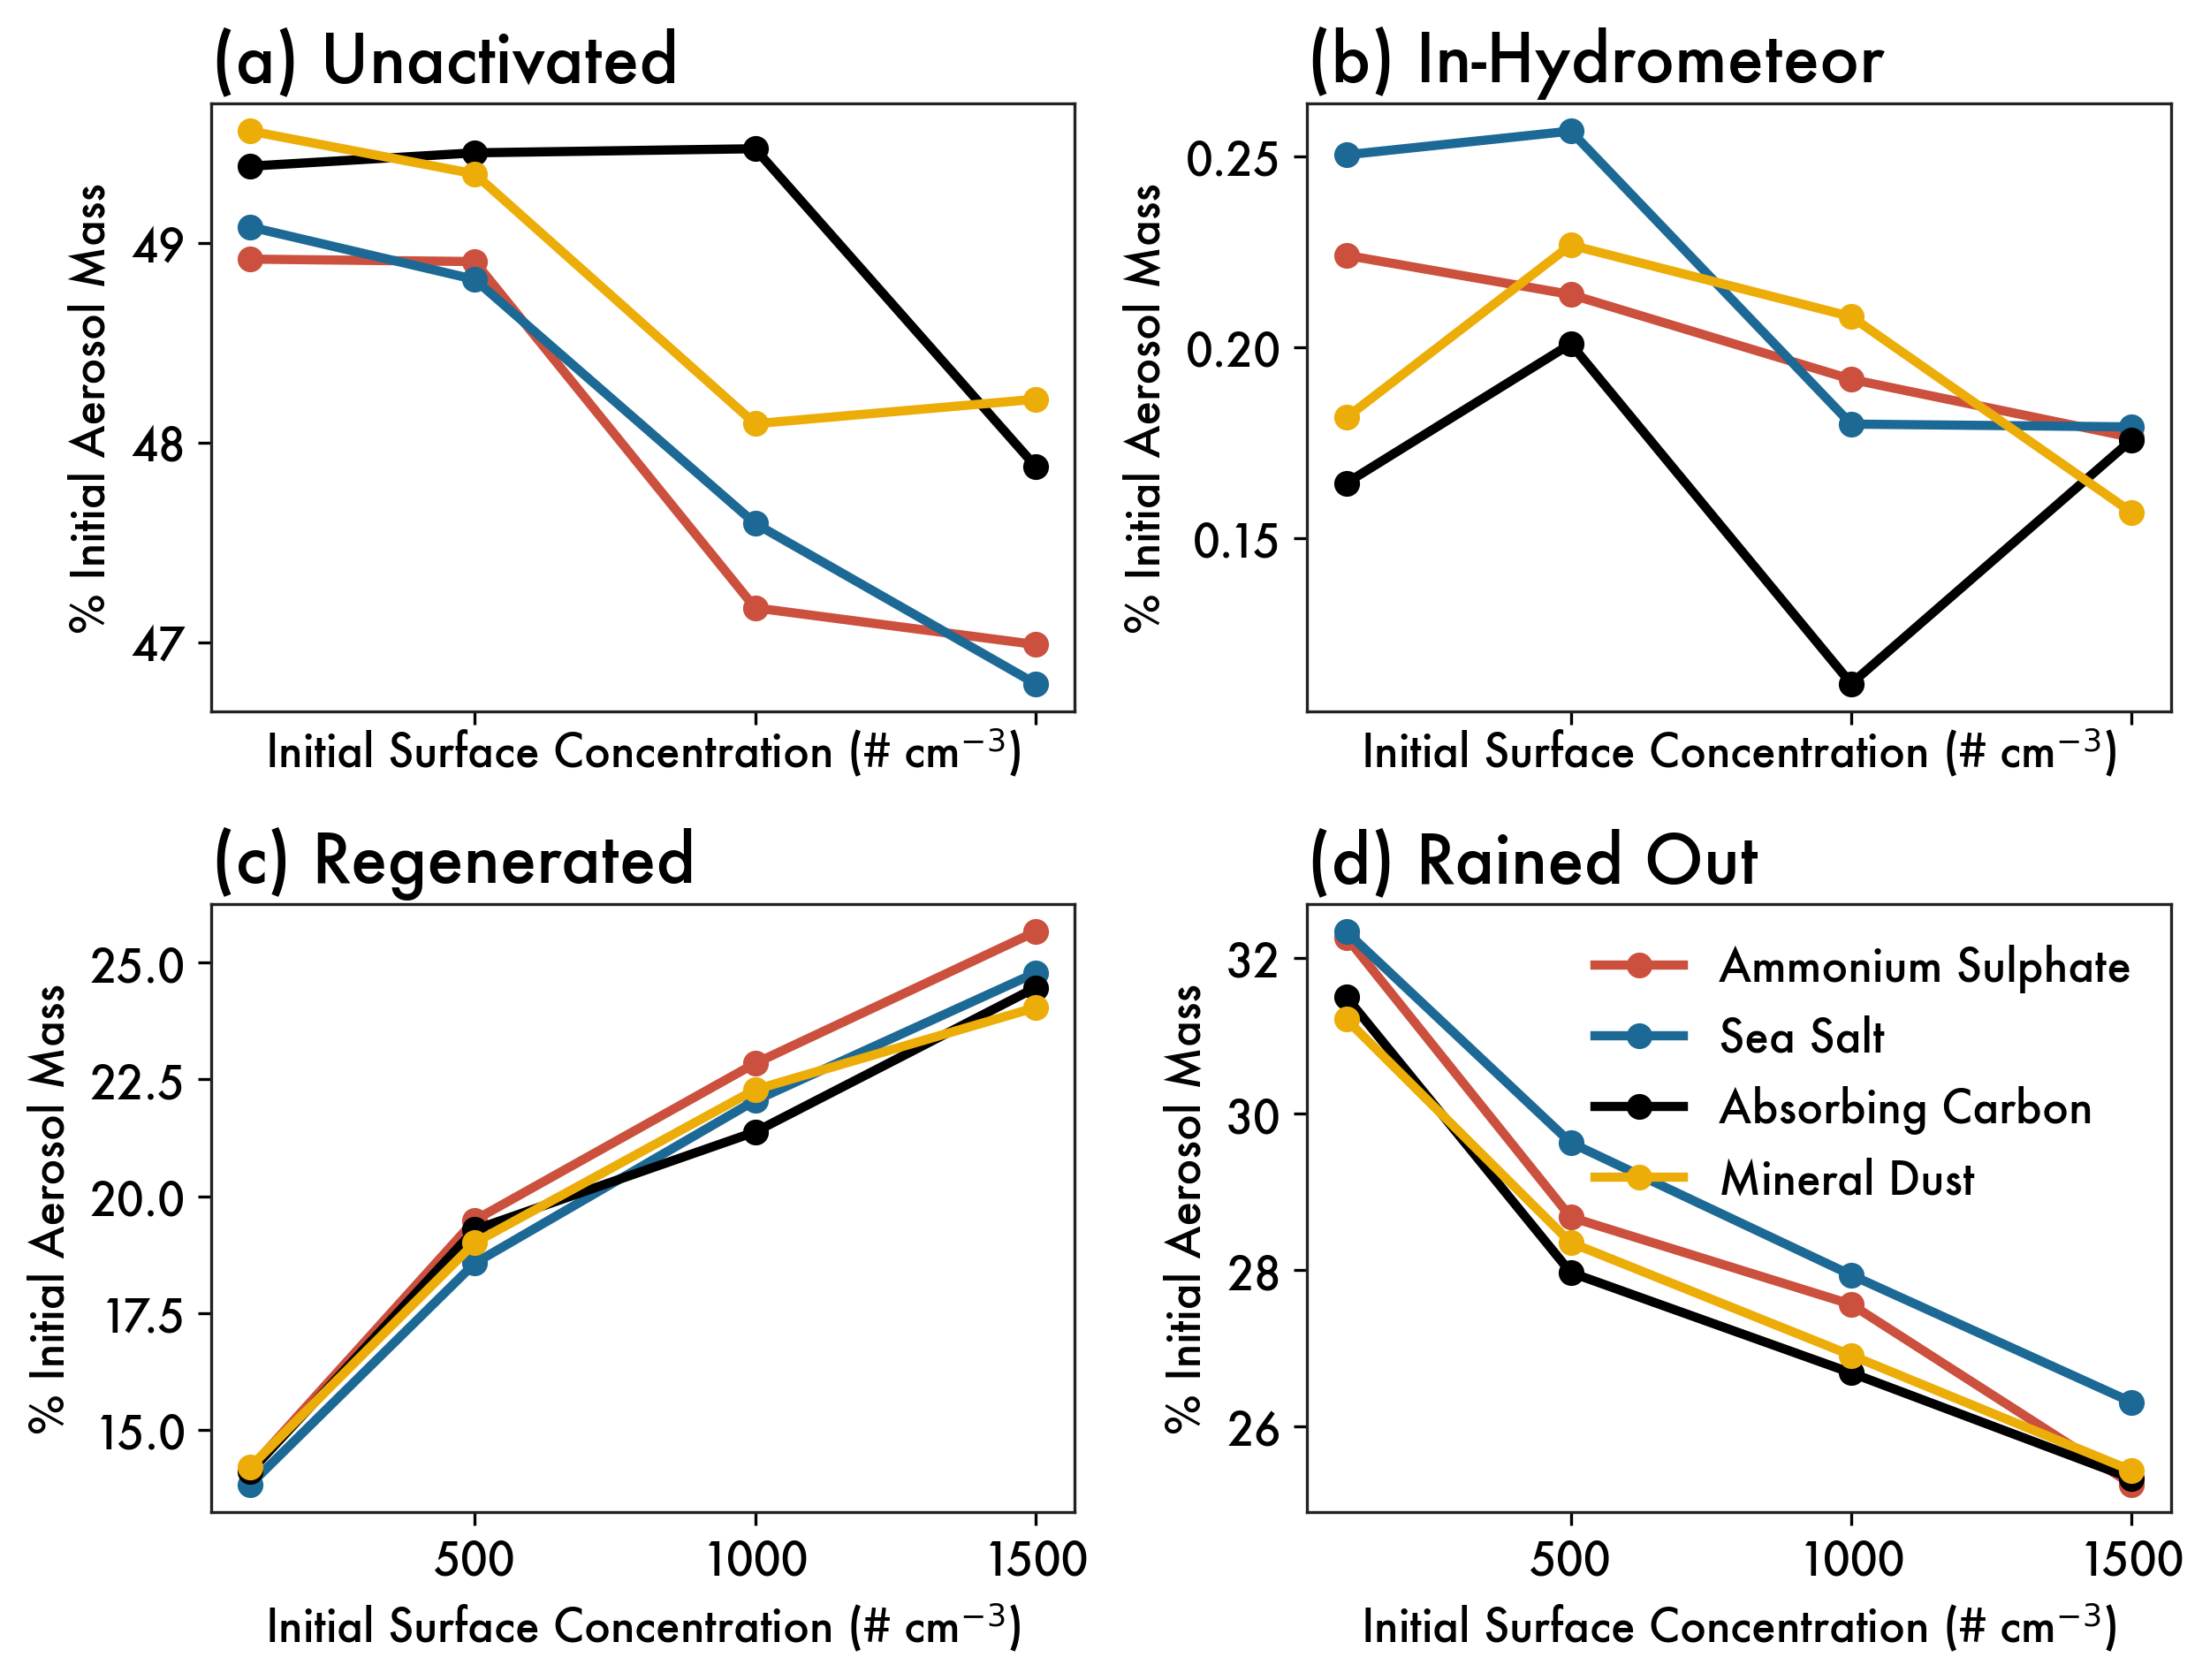

In [10]:
#Have taken the average on each vertical level (units are # or kg / kg), 
#but now need to weight those by the density (to get to # or kg / m^3) 
#and by volume of level if want to vertically integrate (to get to # or kg in column)

dn0 = xr.open_dataset(f"/squall/gleung/aerobudget/sulf.500/a-A-2019-09-16-000000-g1.h5",
                      engine='h5netcdf',phony_dims='access')['DN0'].sel(phony_dim_0=500,phony_dim_1=500)
dn0 = dn0.to_dataframe()
dn0 = dn0[1:119].reset_index()['DN0']

weight_all = dn0*dz[1:119].reset_index()[0]*dx*dx

weight_mid = dn0*dz[1:119].reset_index()[0]*dx*dx
weight_mid[(alt<3000) | (alt>7000)] = 0

concs = [100,500,1000,1500]

fig, axes = plt.subplots(2,2,figsize=(8.5,6.5),
                        sharex=True)
axes = axes.flatten()

for ver,col in zip(['sulf','salt','absc','dust'],[red,blue,lcol,yellow]):
    for i, (ax, var, vlab) in enumerate(zip(axes,
                                      ['unpro_aero','hydro_aero','regen_aero','wtdep_aero'],
                                     ['Unactivated','In-Hydrometeor','Regenerated','Rained Out'])):
        plot = []
        
        for conc in concs:
            run = f"{ver}.{conc}"
            bs = pd.read_pickle(f"{anaPath}{run}/domain_byalt/unpro_aero.pkl").loc[0]
            df = pd.read_pickle(f"{anaPath}{run}/domain_byalt/{var}.pkl")
            
            if 'wtdep' in var:
                df = (df*dx*dx)[0]
            else:
                df = (df*weight_all).sum(axis=1)
                
            bs = (bs*weight_all).sum()
            
            plot.append(100*df.iloc[-1]/bs)

        ax.plot(concs,plot, color=col, marker='o', label = labels.Name.loc[ver])
        ax.set_title(f"({char[i]}) {vlab}")
        ax.set_xlabel('Initial Surface Concentration (# cm$^{-3}$)')
        ax.set_ylabel('% Initial Aerosol Mass')

axes[-1].legend()
#add_legend(ax)
fig.patch.set_facecolor(bg)

plt.savefig(f"{figPath}/fig2-aerobudget-domain-overview.png",dpi=300, bbox_inches='tight')
plt.show()

# Figure 3. In-cloud changes to DSD

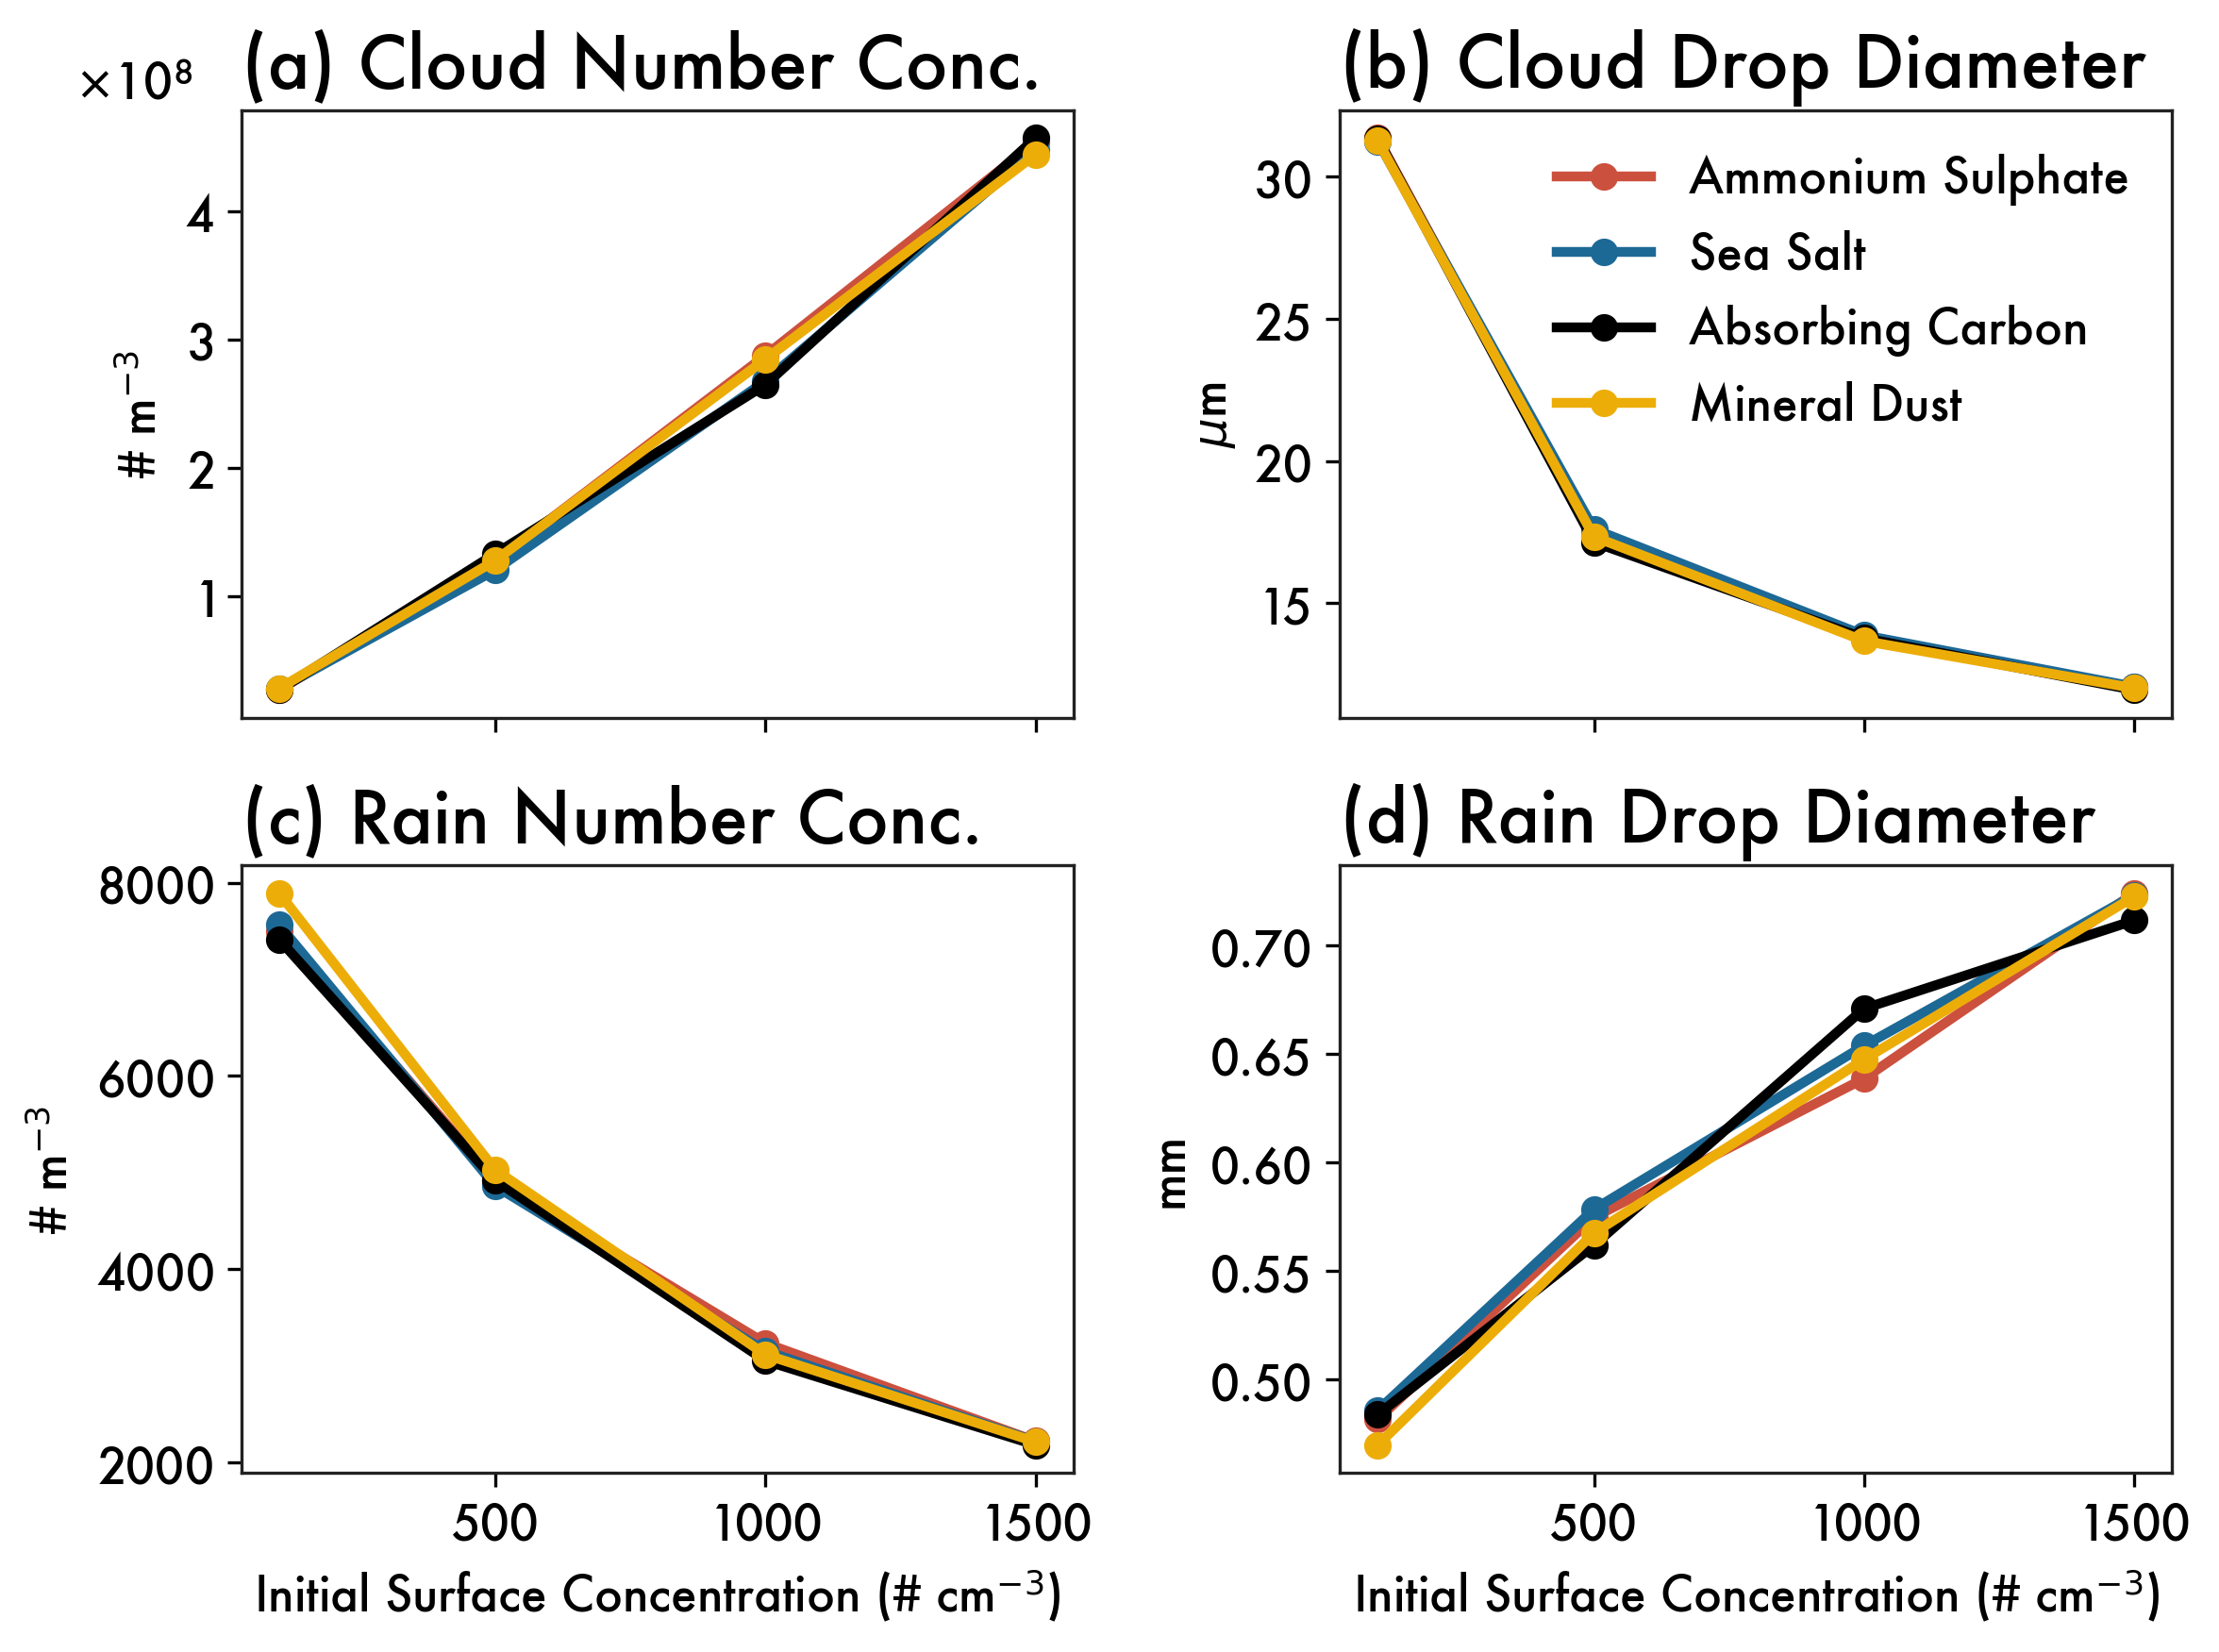

In [12]:
fig, axes = plt.subplots(2,2,sharex=True,figsize=(8,6))

for ax, var in zip(axes.flatten(),['CCP','CDIAM','CRP','RDIAM']):
    for ver,col in zip(['sulf','salt','absc','dust','salt'],[red,blue,lcol,yellow]):
        runs = [f"{ver}.{conc}" for conc in [100,500,1000,1500]]
        plot = []
        for run in runs:
            if var == 'CDIAM':
                r = pd.read_pickle(f"{anaPath}{run}/domain_byalt/RCP_incloud_mean.pkl") 
                c = pd.read_pickle(f"{anaPath}{run}/domain_byalt/CCP_incloud_mean.pkl")

                #calculate diameter of drop in microns with RAMS formula
                df = 1E6*(r/(c*524))**(1/3)
                df[(r<1E-10) & (c<1E-10)] = 0
                
                c = c*dn0
                df = (df*c).sum().sum()/c.sum().sum() #weighted mean
            elif var == 'RDIAM':
                r = pd.read_pickle(f"{anaPath}{run}/domain_byalt/RRP_incloud_mean.pkl")
                c = pd.read_pickle(f"{anaPath}{run}/domain_byalt/CRP_incloud_mean.pkl")

                #calculate diameter of drop in microns with RAMS formula
                df = 1E3*(r/(c*524))**(1/3)
                df[(r<1E-10) & (c<1E-10)] = 0
                
                c = c*dn0 #convert #/kg to #/m^3 to weight by density
                df = (df*c).sum().sum()/c.sum().sum() #weighted mean
            else:
                df = pd.read_pickle(f"{anaPath}{run}/domain_byalt/{var}_incloud_mean.pkl")
                df = np.nanmean((df*dn0).values)
                
            plot.append(df)

        ax.plot([100,500,1000,1500],plot, 
                 color=col, marker='o',
               label = labels.Name.loc[ver])
        
axes[0,0].set_title('(a) Cloud Number Conc.')
axes[0,1].set_title('(b) Cloud Drop Diameter')
axes[1,0].set_title('(c) Rain Number Conc.')
axes[1,1].set_title('(d) Rain Drop Diameter')

for ax in axes.T[0]:
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    ax.get_yaxis().get_offset_text().set_position((-0.2,0)) 

axes[0,1].legend()

for ax in axes[1]:
    ax.set_xlabel('Initial Surface Concentration (# cm$^{-3}$)')
    
axes[0,0].set_ylabel('# m$^{-3}$')
axes[0,1].set_ylabel('$\mu$m')
axes[1,0].set_ylabel('# m$^{-3}$')
axes[1,1].set_ylabel('mm')

fig.patch.set_facecolor(bg)
plt.savefig(f"{figPath}/fig3-dropsize-incloud-overview.png",dpi=300,bbox_inches='tight')
plt.show()

# Fig 4. Microphysics process changes

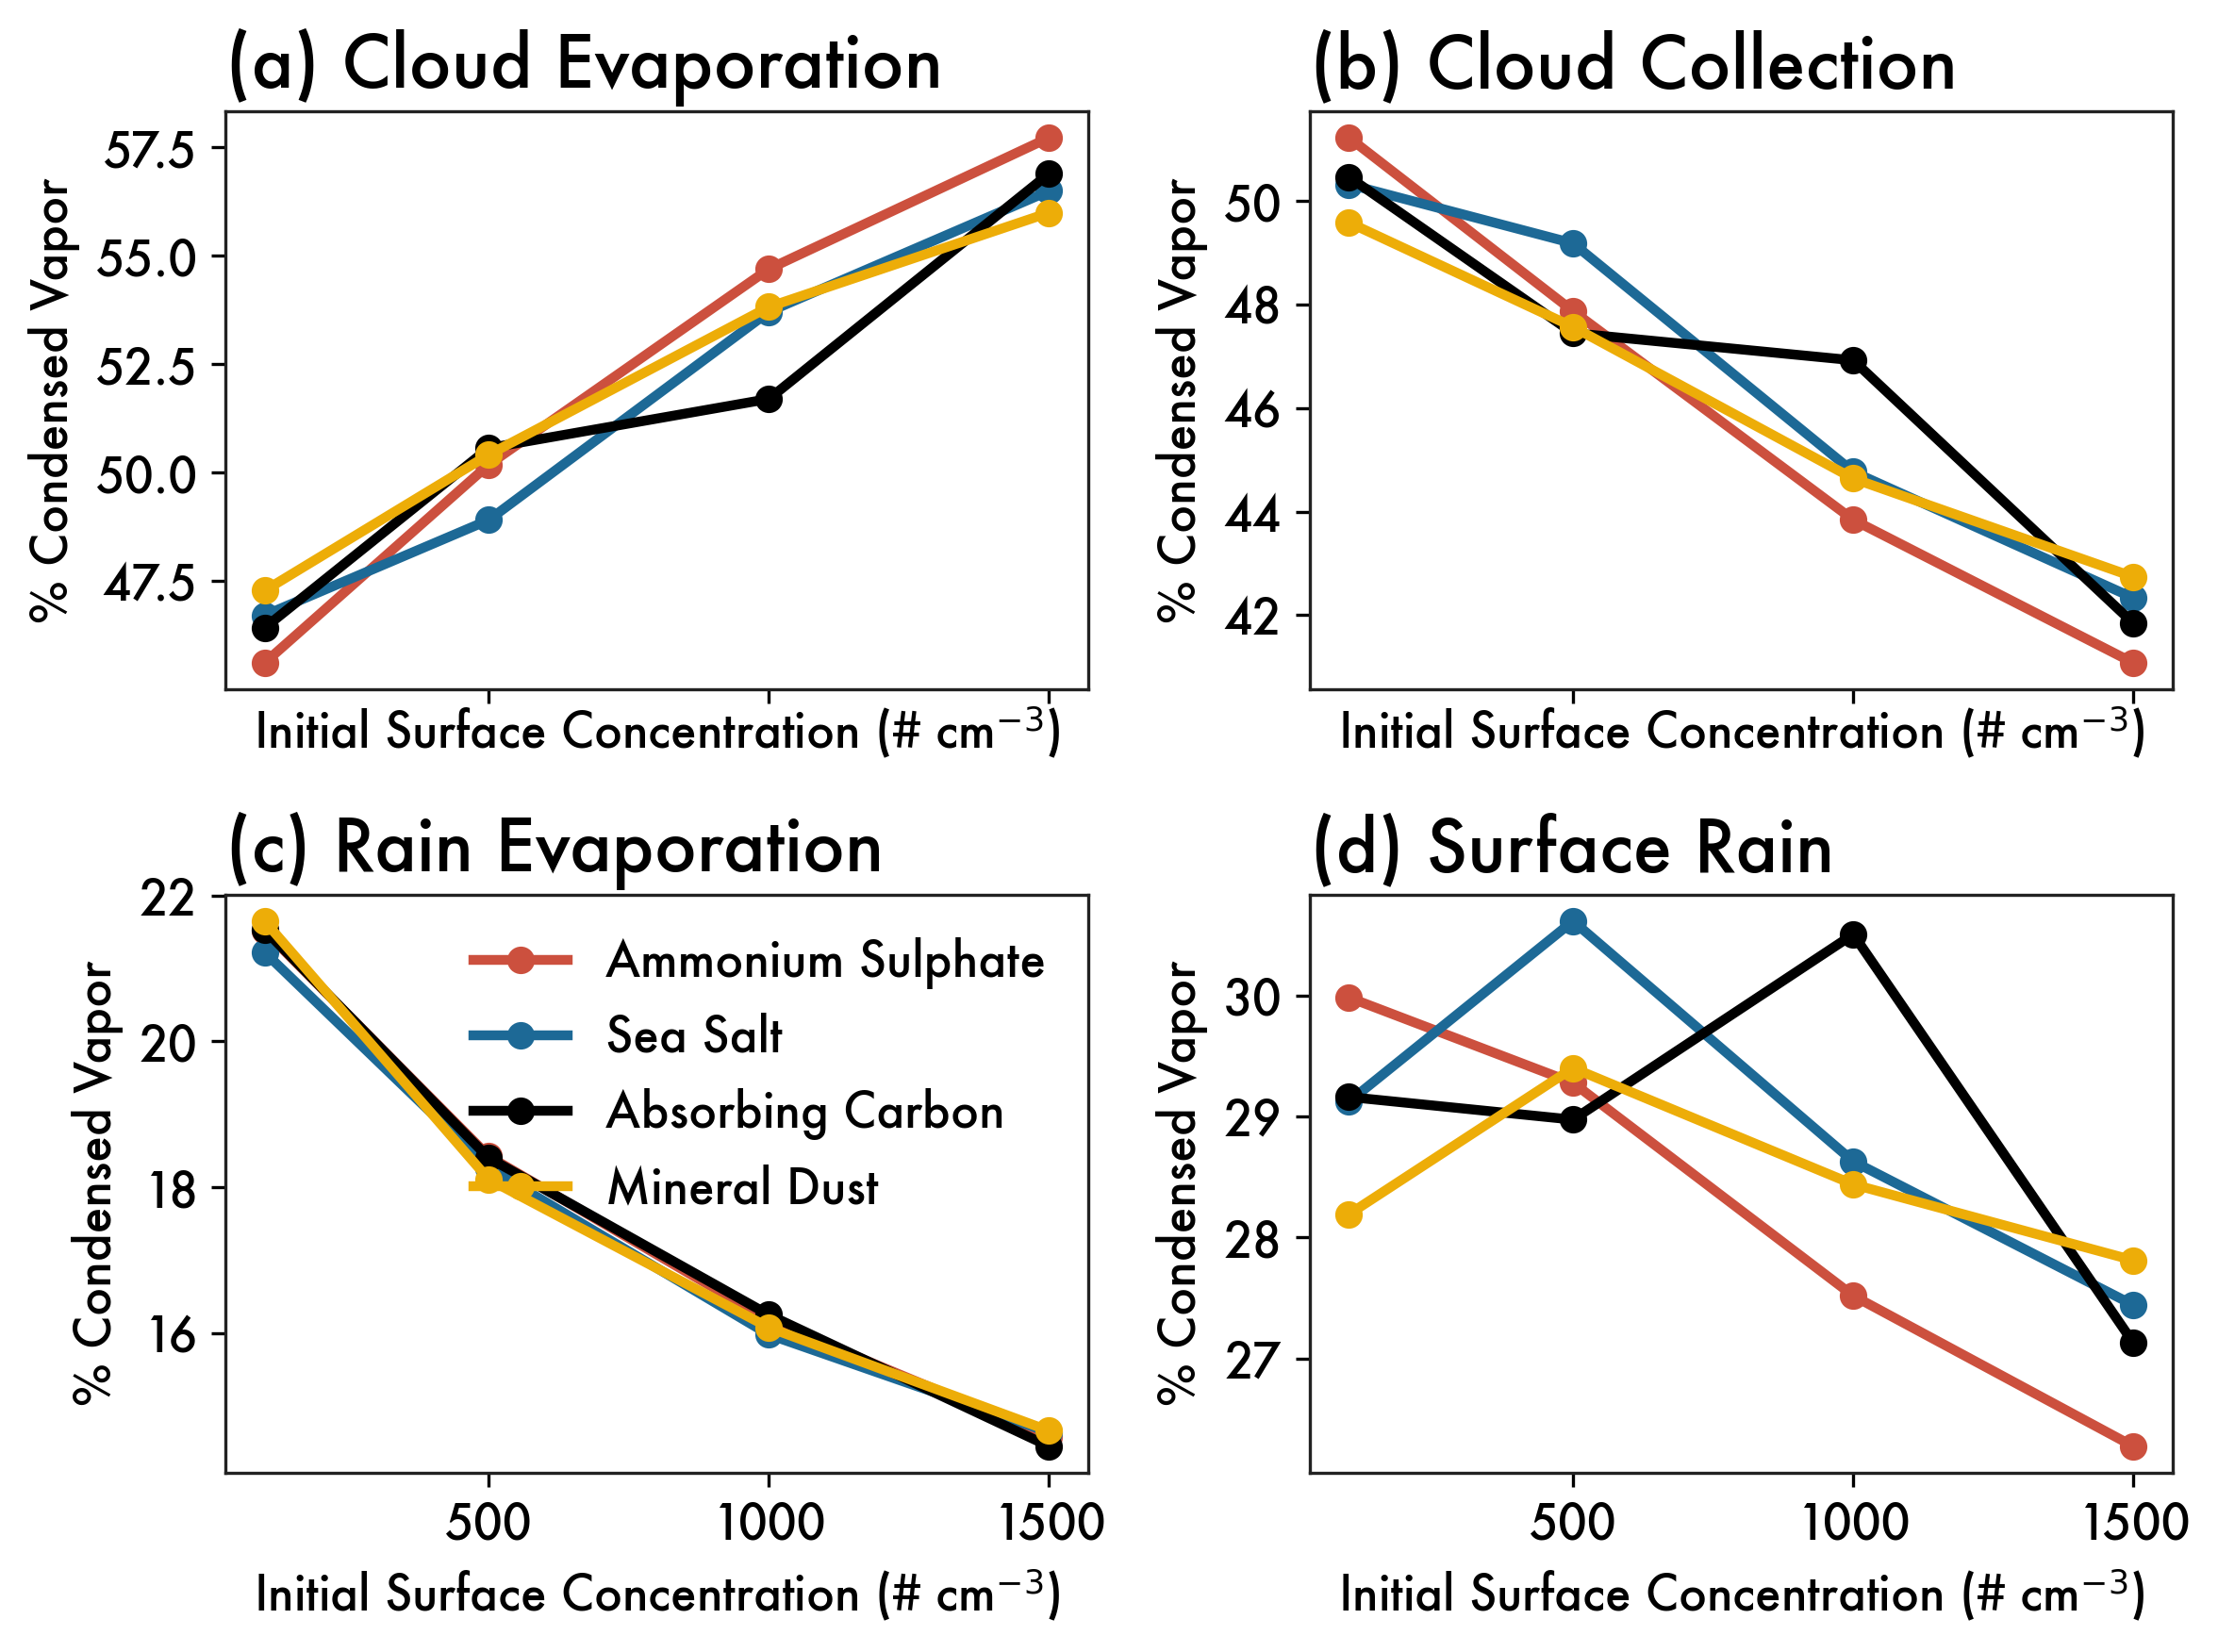

In [13]:
fig, axes = plt.subplots(2,2,sharex=True,figsize=(8,6))

axes = axes.flatten()

for i, (ax, var, vlab) in enumerate(zip(axes,['evapcldt','cld2raint','evapraint','accpr'],
                                       ['Cloud Evaporation','Cloud Collection','Rain Evaporation','Surface Rain'])):
    base = pd.read_pickle(f"{anaPath}/comparison/proc-vt_nuccldrt.pkl") + pd.read_pickle(f"{anaPath}/comparison/proc-vt_vapcldt.pkl") 
    base = base.sum()
    
    if var!='accpr':
        df = pd.read_pickle(f"{anaPath}/comparison/proc-vt_{var}.pkl").sum()
    else:
        df = pd.read_pickle(f"{anaPath}/comparison/proc-{var}.pkl").iloc[-1]
        

    for ver,col in zip(['sulf','salt','absc','dust'],[red,blue,lcol,yellow]):
        runs = [f"{ver}.{conc}" for conc in concs]
        plot = []

        for run in runs:
            plot.append(100*df[run]/base[run])
            
        ax.plot(concs,plot,color=col, marker='o', label = labels.Name.loc[ver])
        

    ax.set_title(f"({char[i]}) {vlab}")
    ax.set_xlabel('Initial Surface Concentration (# cm$^{-3}$)')
    
    ax.set_ylabel('% Condensed Vapor')

axes[2].legend()
fig.patch.set_facecolor(bg)

plt.savefig(f"{figPath}/fig4-processrates-domain-efficiency.png",dpi=300, bbox_inches='tight')
plt.show()

# Fig 5. Cloud population and domain-precip changes

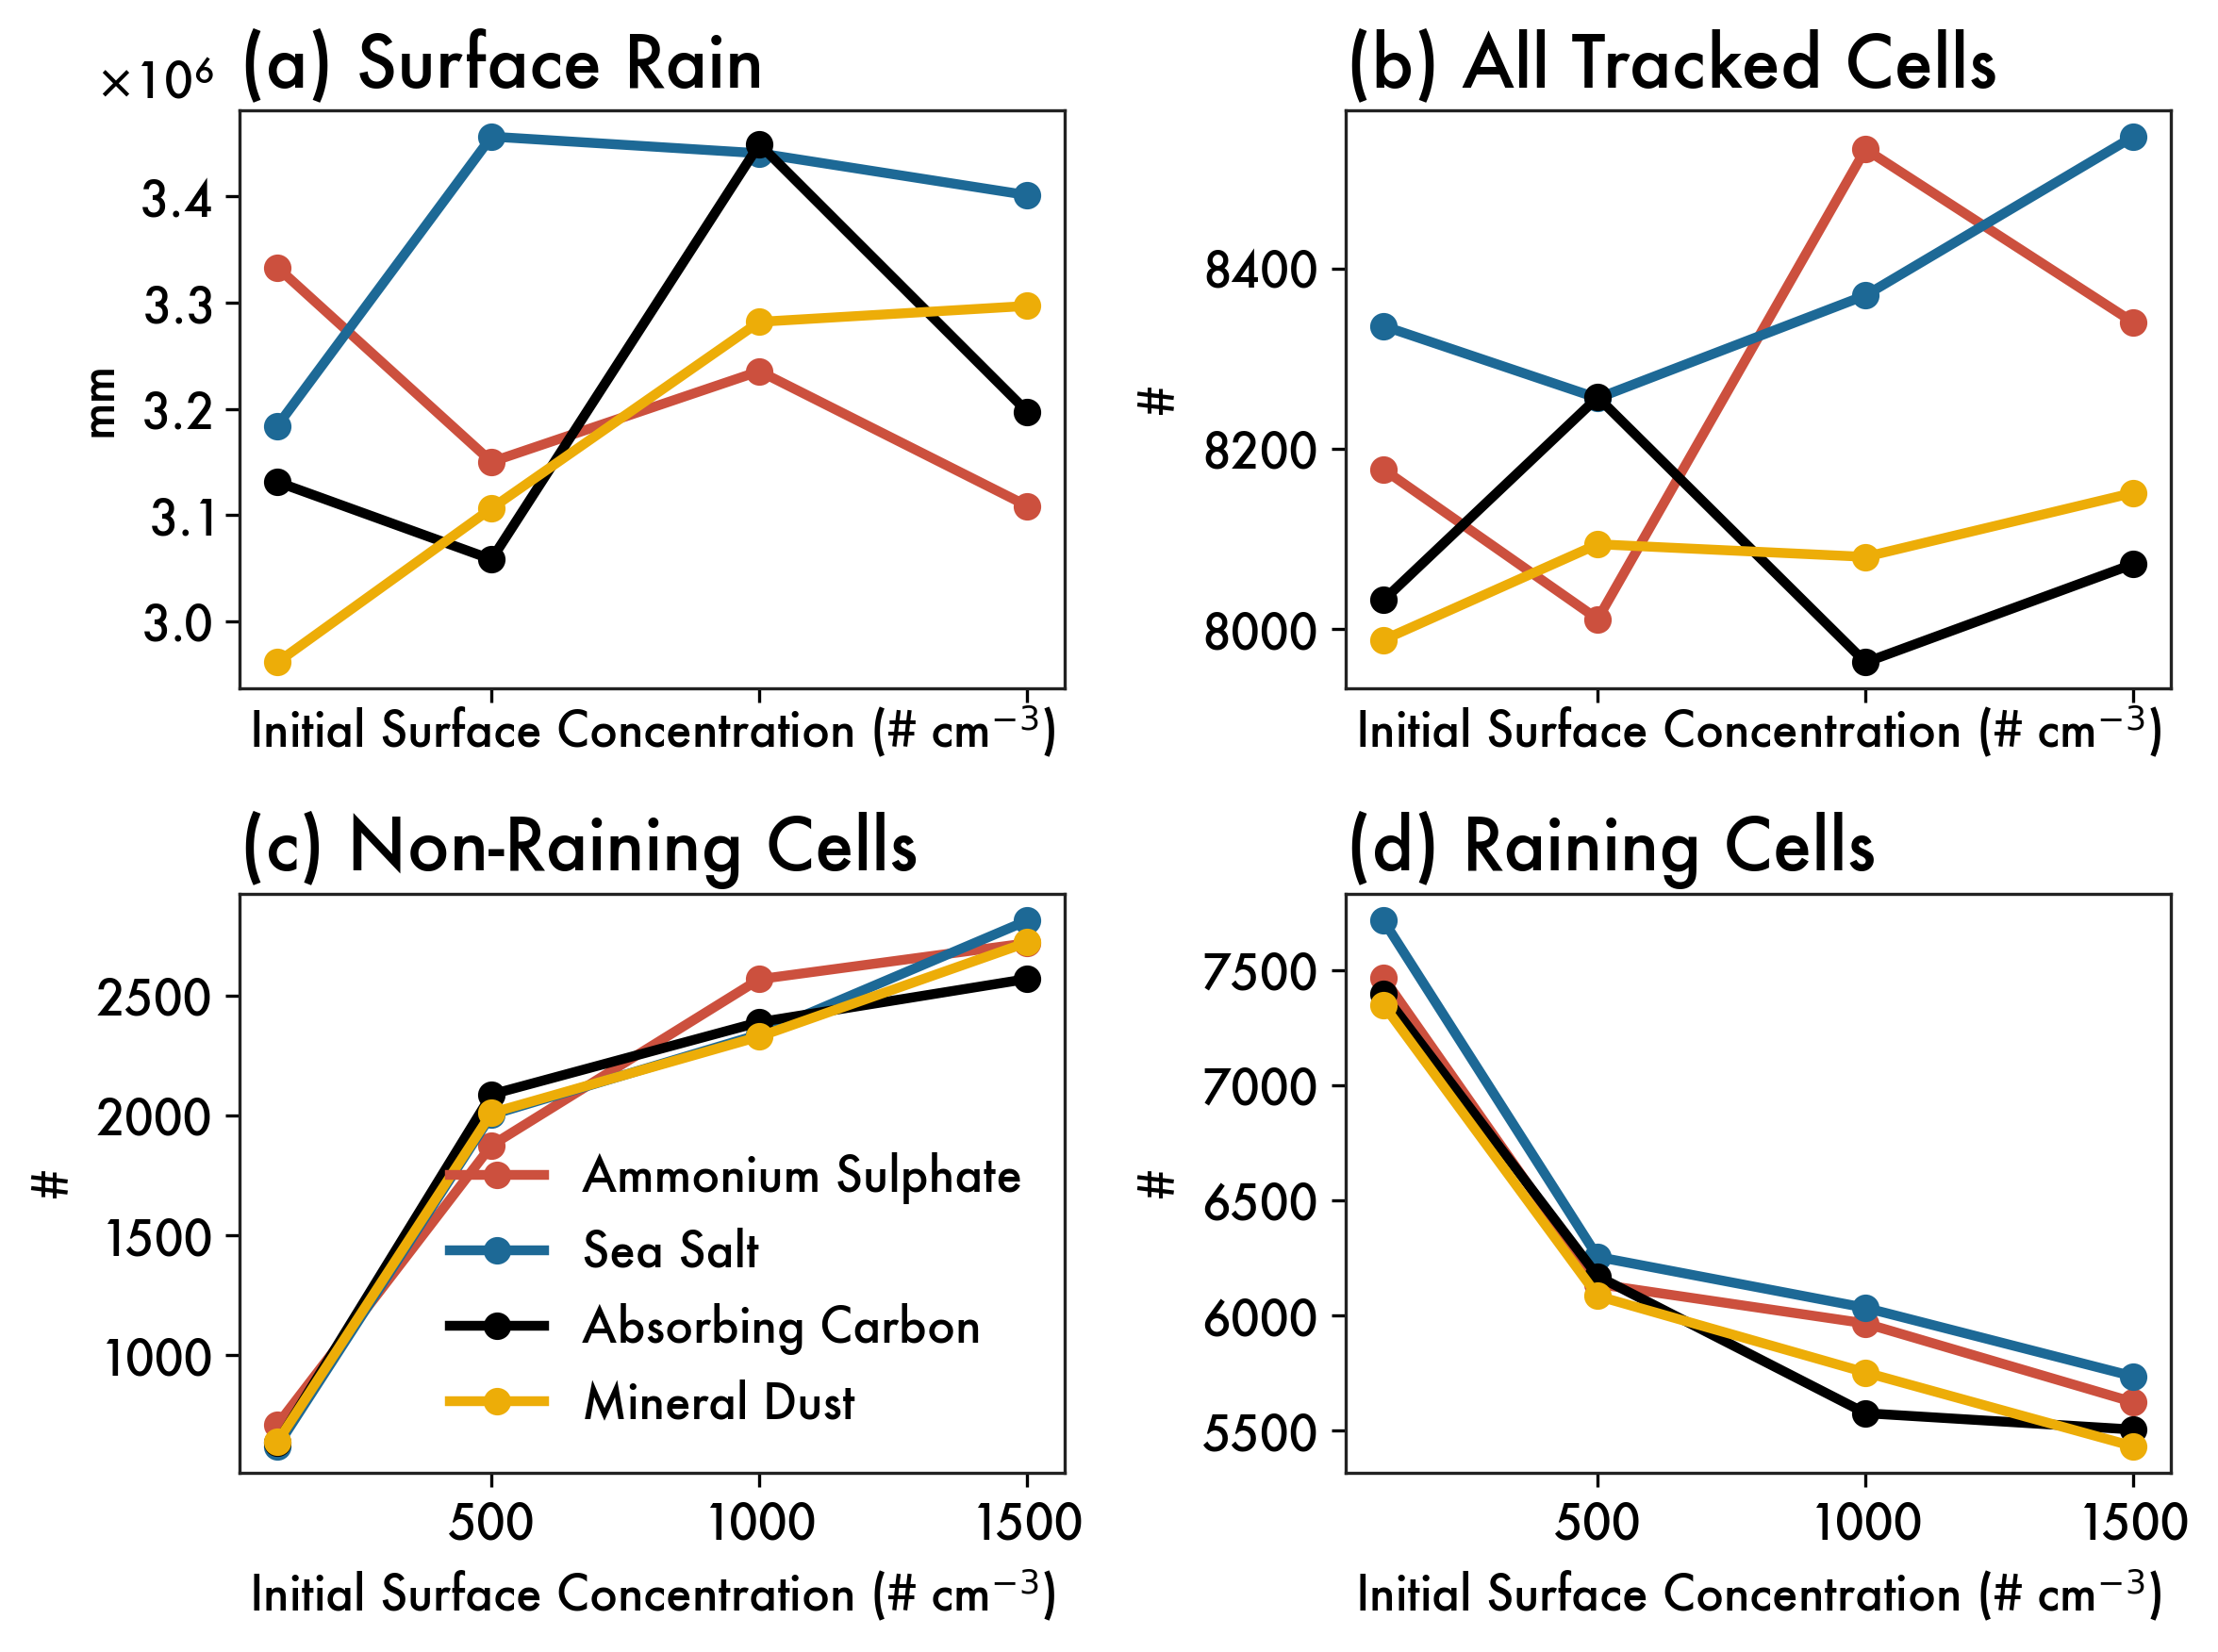

In [13]:
min_rain = 1E-4

fig, axes = plt.subplots(2,2,sharex=True,figsize=(8,6))
axes = axes.flatten()

for ver,col in zip(['sulf','salt','absc','dust'],[red,blue,lcol,yellow]):   
    runs = [f"{ver}.{conc}" for conc in concs]
    
    plot = []
    plot_raining = []
    plot_nonraining = []
    plot_rain = []
    
    for run in runs:
        df = pd.read_pickle(f"{anaPath}{run}/tobac/full_tobac_output.pkl").groupby('cell').mean()

        plot.append(len(df))
        plot_raining.append(len(df[df.cellmax_mean_pcprr>=min_rain]))
        plot_nonraining.append(len(df[~(df.cellmax_mean_pcprr>=min_rain)]))
        
        df = pd.read_pickle(f"{anaPath}/comparison/proc-accpr.pkl").iloc[-1][run]
        
        plot_rain.append(df)
        
    axes[1].plot(concs, plot, color=col, marker='o', label = labels.Name.loc[ver])
    axes[0].plot(concs, plot_rain, color=col, marker='o', label = labels.Name.loc[ver])
    axes[2].plot(concs, plot_nonraining, color=col, marker='o', label = labels.Name.loc[ver])
    axes[3].plot(concs, plot_raining, color=col, marker='o', label = labels.Name.loc[ver])
    
axes[1].set_title(f"(b) All Tracked Cells")
axes[0].set_title(f"(a) Surface Rain")
axes[2].set_title(f"(c) Non-Raining Cells")
axes[3].set_title(f"(d) Raining Cells")
    
for ax in axes:
    ax.set_xlabel('Initial Surface Concentration (# cm$^{-3}$)')

for ax in axes[1:]:
    ax.set_ylabel('#')
    
axes[0].set_ylabel('mm')
axes[0].yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
axes[0].get_yaxis().get_offset_text().set_position((-0.175,0))  

axes[2].legend()

fig.patch.set_facecolor(bg)
plt.savefig(f"{figPath}/fig5-tobac-overview-cellcounts.png",dpi=300, bbox_inches='tight')
plt.show()

# Fig 6. Changes to cloud median properties

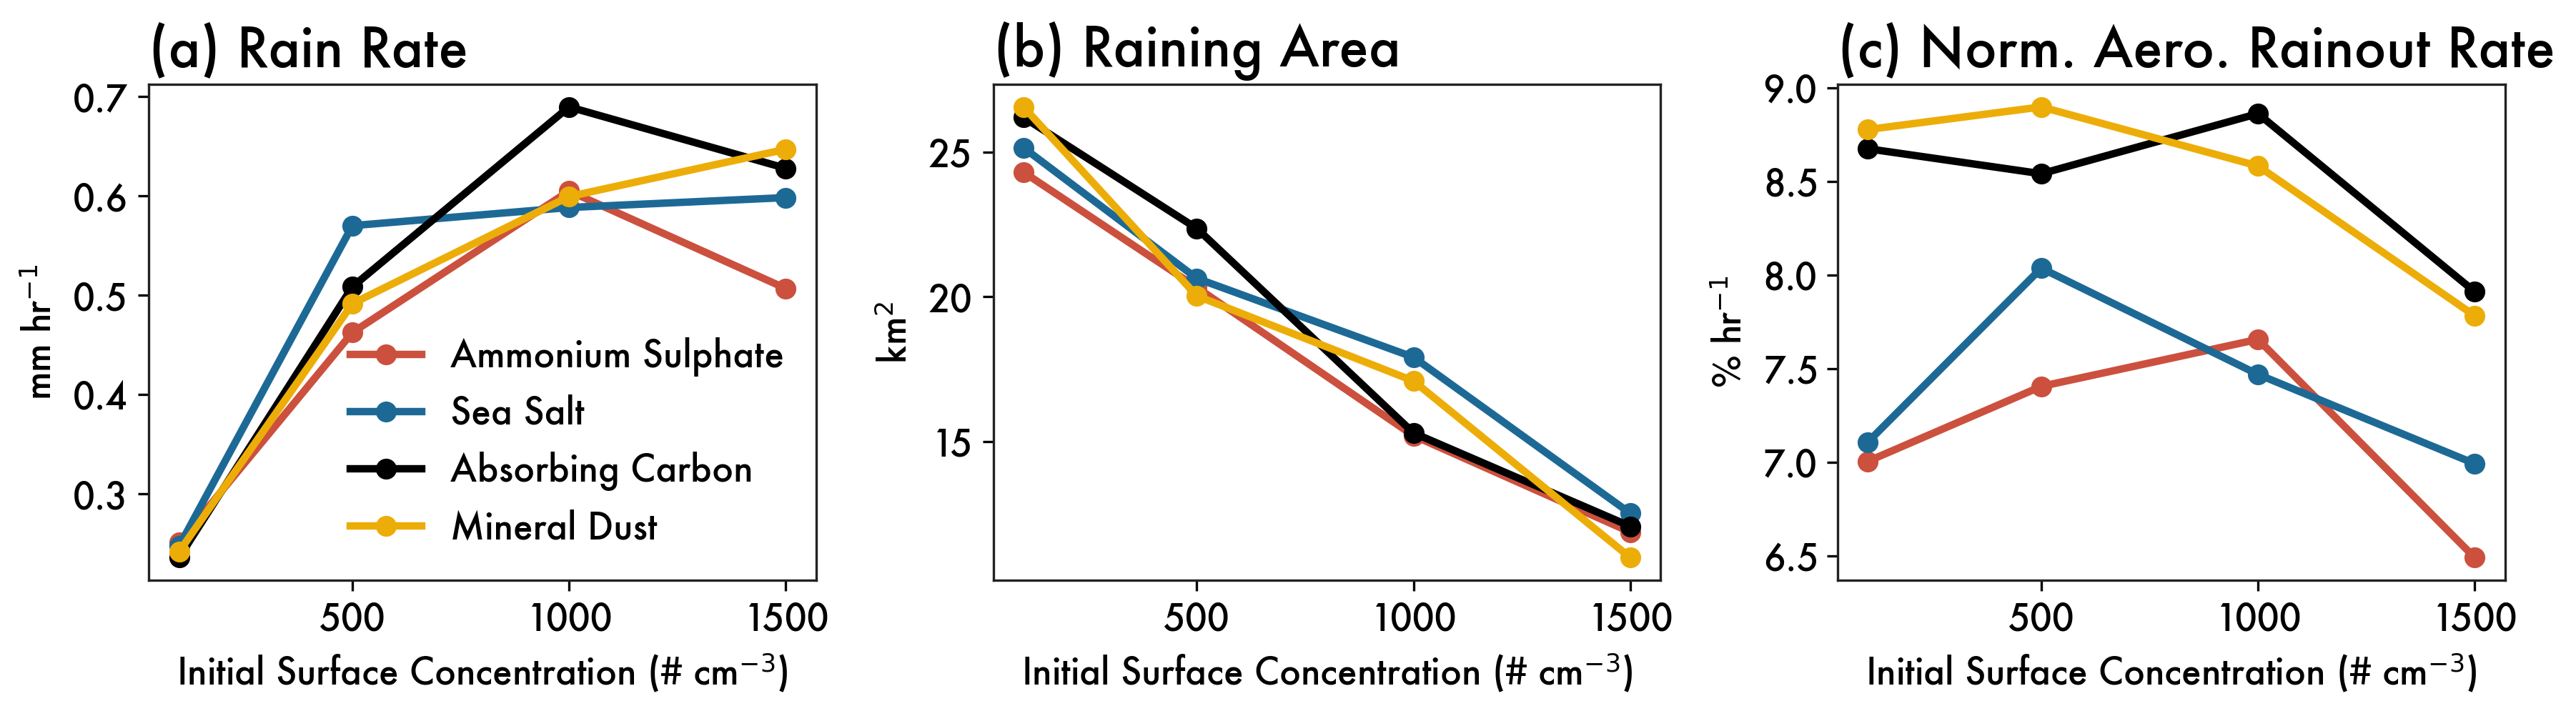

In [9]:
min_rain = 1E-4
min_up = 1

fig, axes = plt.subplots(1,3,sharex=True,figsize=(12,3.5))

axes = axes.flatten()

for ver,col in zip(['sulf','salt','absc','dust'],[red,blue,lcol,yellow]):   
    runs = [f"{ver}.{conc}" for conc in concs]
    
    plot_pcp = []
    plot_wtdep_n = []
    plot_area = []
    plot_time = []
    
    for run in runs:
        bs = pd.read_pickle(f"{anaPath}{run}/domain_byalt/unpro_aero.pkl").loc[0] #total initial aerosol mass per altitude
        bs = (bs*weight_all).sum() #total initial aerosol mass over whole domain
        bs = bs / (nx*ny*dx*dy) #initial aerosol mass in one column

        df = pd.read_pickle(f"{anaPath}{run}/tobac/full_tobac_output.pkl")
        df['cellsum_raining_area'] = df.cell.map(df.groupby('cell').raining_area.sum())
        df['lifetime'] = df.lifetime/ddt.timedelta(minutes=1)
        df['time_raining'] = df.time_raining/ddt.timedelta(minutes=1)
        
        df = df.groupby('cell').mean()
        
        df = df[df.cellmax_mean_pcprr>=min_rain]
        df = df[df.cellmax_maxW>=min_up]
        
        #median of all cells, maximum updraft reached over whole lifetime
        plot_pcp.append(df.cellmax_mean_pcprr.median())
        plot_wtdep_n.append(100*df.cellmax_mean_wtdep.median()/bs)
        plot_area.append(df.cellsum_raining_area.median())
        
    axes[0].plot(concs, plot_pcp, color=col, marker='o', label = labels.Name.loc[ver])
    axes[2].plot(concs, plot_wtdep_n, color=col, marker='o', label = labels.Name.loc[ver])
    axes[1].plot(concs, plot_area,color=col, marker='o', label = labels.Name.loc[ver])
    
axes[0].set_title('(a) Rain Rate')
axes[2].set_title('(c) Norm. Aero. Rainout Rate')
axes[1].set_title('(b) Raining Area')

axes[0].set_ylabel('mm hr$^{-1}$')
axes[2].set_ylabel('% hr$^{-1}$')
axes[1].set_ylabel('km$^{2}$')

for ax in axes[2:]:
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    ax.get_yaxis().get_offset_text().set_position((-0.25,0)) 

for ax in axes:
    ax.set_xlabel('Initial Surface Concentration (# cm$^{-3}$)')
    
axes[0].legend()

fig.patch.set_facecolor(bg)
plt.savefig(f"{figPath}/fig6-tobac-cloudmedians.png",dpi=300, bbox_inches='tight')
plt.show()

# Fig 7. CTH vs Rain Rate Distribution

/tmp/ipykernel_29228/3851787923.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{figPath}/fig7-raindist.png",dpi=300,bbox_inches='tight')
/home/gleung/miniconda3/envs/detrainbudget/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


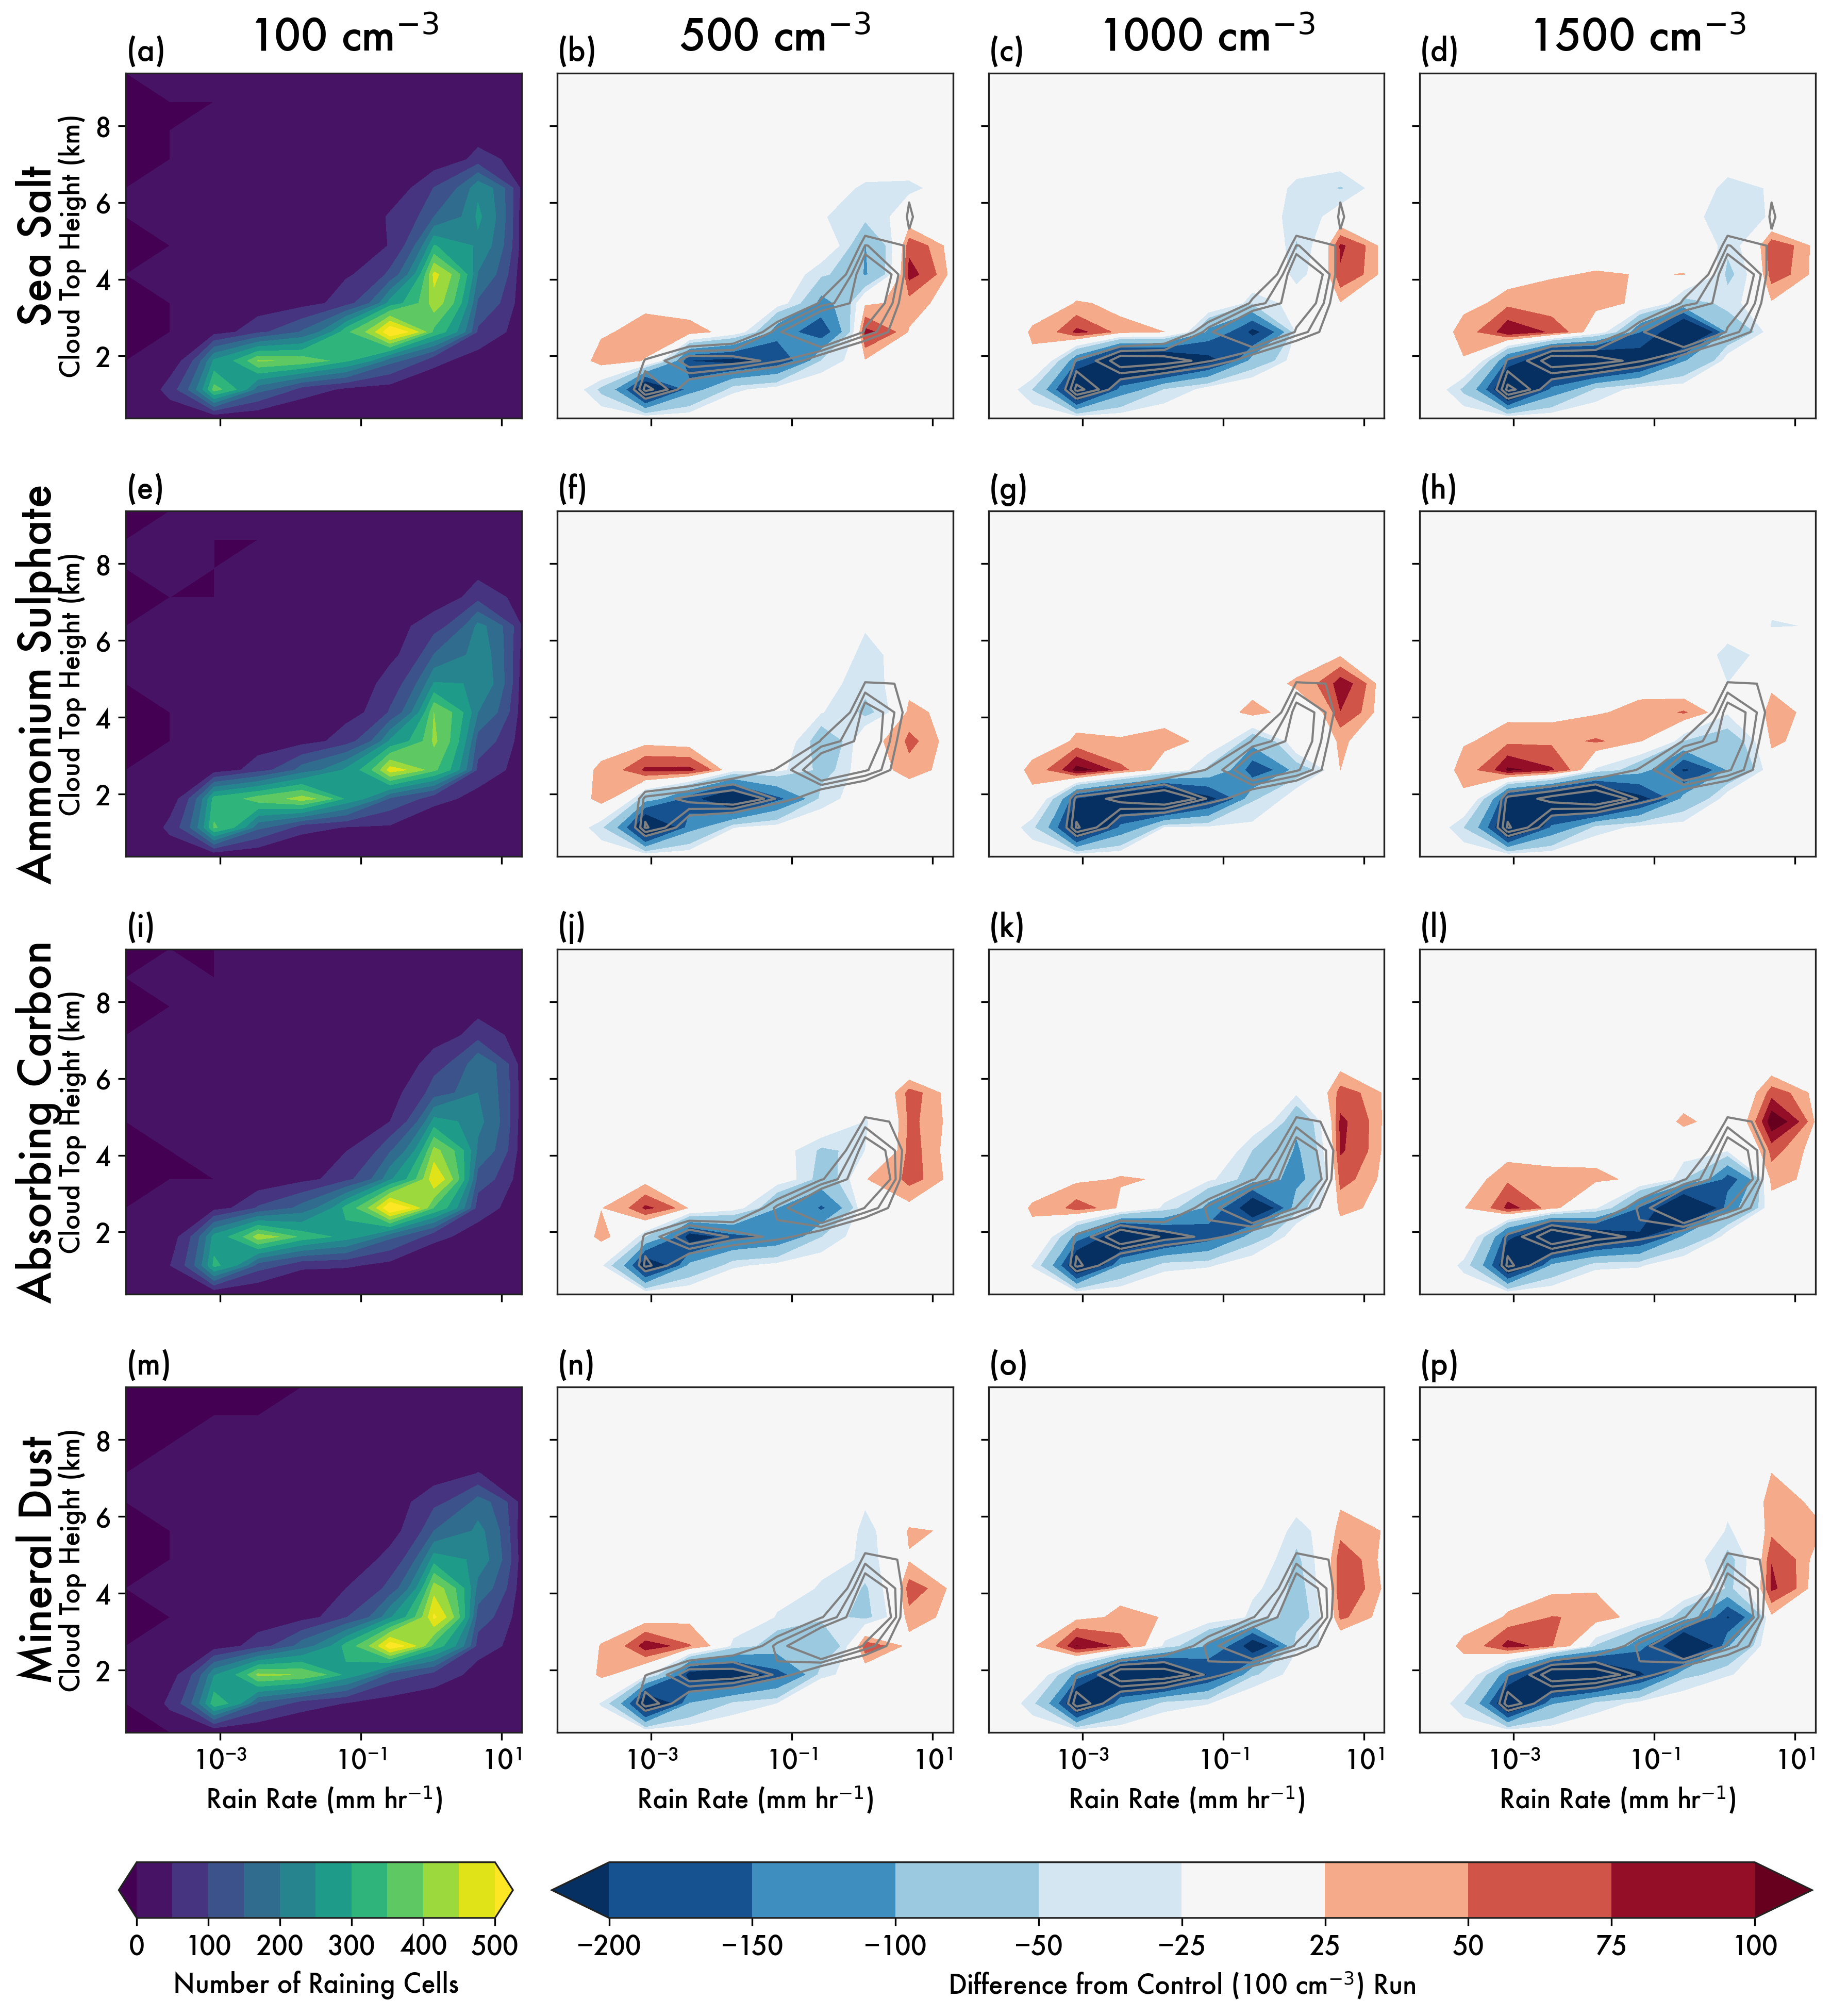

In [10]:
cthbins = np.arange(0,10,0.75)#(alt/1000)[1:80:5].reset_index()[0].values
pcprrbins = np.logspace(-4.75,1.5,11)#np.logspace(-2,1.5,11)    

min_rain = 1E-4

vers = ['salt','sulf','absc','dust']
concs = [100,500,1000,1500]

fig, axess = plt.subplots(4,4,sharex=True,sharey=True, figsize=(12,12))

#plt.subplots_adjust(hspace=0.1, wspace=0.135)

for ax, ver in zip((axess.T)[0], vers):
    ax.set_ylabel('Cloud Top Height (km)')
    ax.text(-0.22, 0.5, labels.Name.loc[ver],
            ha = 'center', va = 'center',
            rotation = 90,
            fontsize = 20, 
           transform = ax.transAxes)
    
for ax in axess[-1]:
    ax.set_xlabel('Rain Rate (mm hr$^{-1}$)')
    
for ax, conc in zip(axess[0], concs):
    ax.text(0.55, 1.1, f"{conc} cm$^{{-3}}$",
           ha = 'center', va='center',
           fontsize=20,
           transform = ax.transAxes)
    ax.set_xscale('log')
    
i = 0
plt.tight_layout()

for axes, ver in zip(axess,vers):
    runs = [f"{ver}.{conc}" for conc in concs]

    for ax, run in zip(axes, runs):
        out = pd.read_pickle(f"{anaPath}{run}/tobac/full_tobac_output.pkl")
        out = out[out.cellmax_mean_pcprr>=min_rain]
        
        out = out.groupby('cell').mean()
    
        plot = np.histogram2d(out.cellmax_CTH.values, 
                              out.cellmax_mean_pcprr.values, 
                              bins = (cthbins, pcprrbins))
        out = plot[0] 
        
        if run.endswith('100'):
            c = ax.contourf((pcprrbins[1:]+pcprrbins[:-1])/2,
                            (cthbins[1:]+cthbins[:-1])/2, 
                    out, 
                    levels=np.linspace(0,500,11), 
                    extend='both')
            base = out.copy()
            
        else:
            out = out-base
            d = ax.contourf((pcprrbins[1:]+pcprrbins[:-1])/2,
                            (cthbins[1:]+cthbins[:-1])/2,
                        out,cmap='RdBu_r',
                        levels = [-200,-150,-100,-50,-25,25,50,75,100],
                        norm = mcolors.TwoSlopeNorm(vcenter=0),
                            extend='both')
            ax.contour((pcprrbins[1:]+pcprrbins[:-1])/2,
                            (cthbins[1:]+cthbins[:-1])/2,
                       base, colors='gray',
                       levels = [250,300,350],
                      linewidths = 1)
            
        ax.set_title(f"({char[i]})", fontsize=14)
        i+=1
        
        ax.set_xlim((pcprrbins[0]+pcprrbins[1])/2, (pcprrbins[-1]+pcprrbins[-2])/2)
            
    if ver == vers[-1]:
        cax = fig.add_axes([axes[0].get_position().x0,
                    axes[0].get_position().y0-0.1, 
                    axes[0].get_position().x1 - axes[0].get_position().x0,
                    0.03])
        plt.colorbar(c, cax = cax, orientation='horizontal', label = 'Number of Raining Cells')
        
        cax = fig.add_axes([axes[1].get_position().x0,
                    axes[1].get_position().y0-0.1, 
                   axes[-1].get_position().x1 - axes[1].get_position().x0,
                           0.03])
        cbar = plt.colorbar(d,cax=cax, orientation='horizontal', 
                            label = 'Difference from Control (100 cm$^{-3}$) Run',
                            ticks = [-200,-150,-100,-50,-25,25,50,75,100],
                           )

fig.patch.set_facecolor(bg)
plt.savefig(f"{figPath}/fig7-raindist.png",dpi=300,bbox_inches='tight')
plt.show()

# Fig 8. Wet Dep Distribution

/tmp/ipykernel_29228/386992770.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{figPath}/fig8-wetdepdist.png",dpi=300,bbox_inches='tight')
/home/gleung/miniconda3/envs/detrainbudget/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


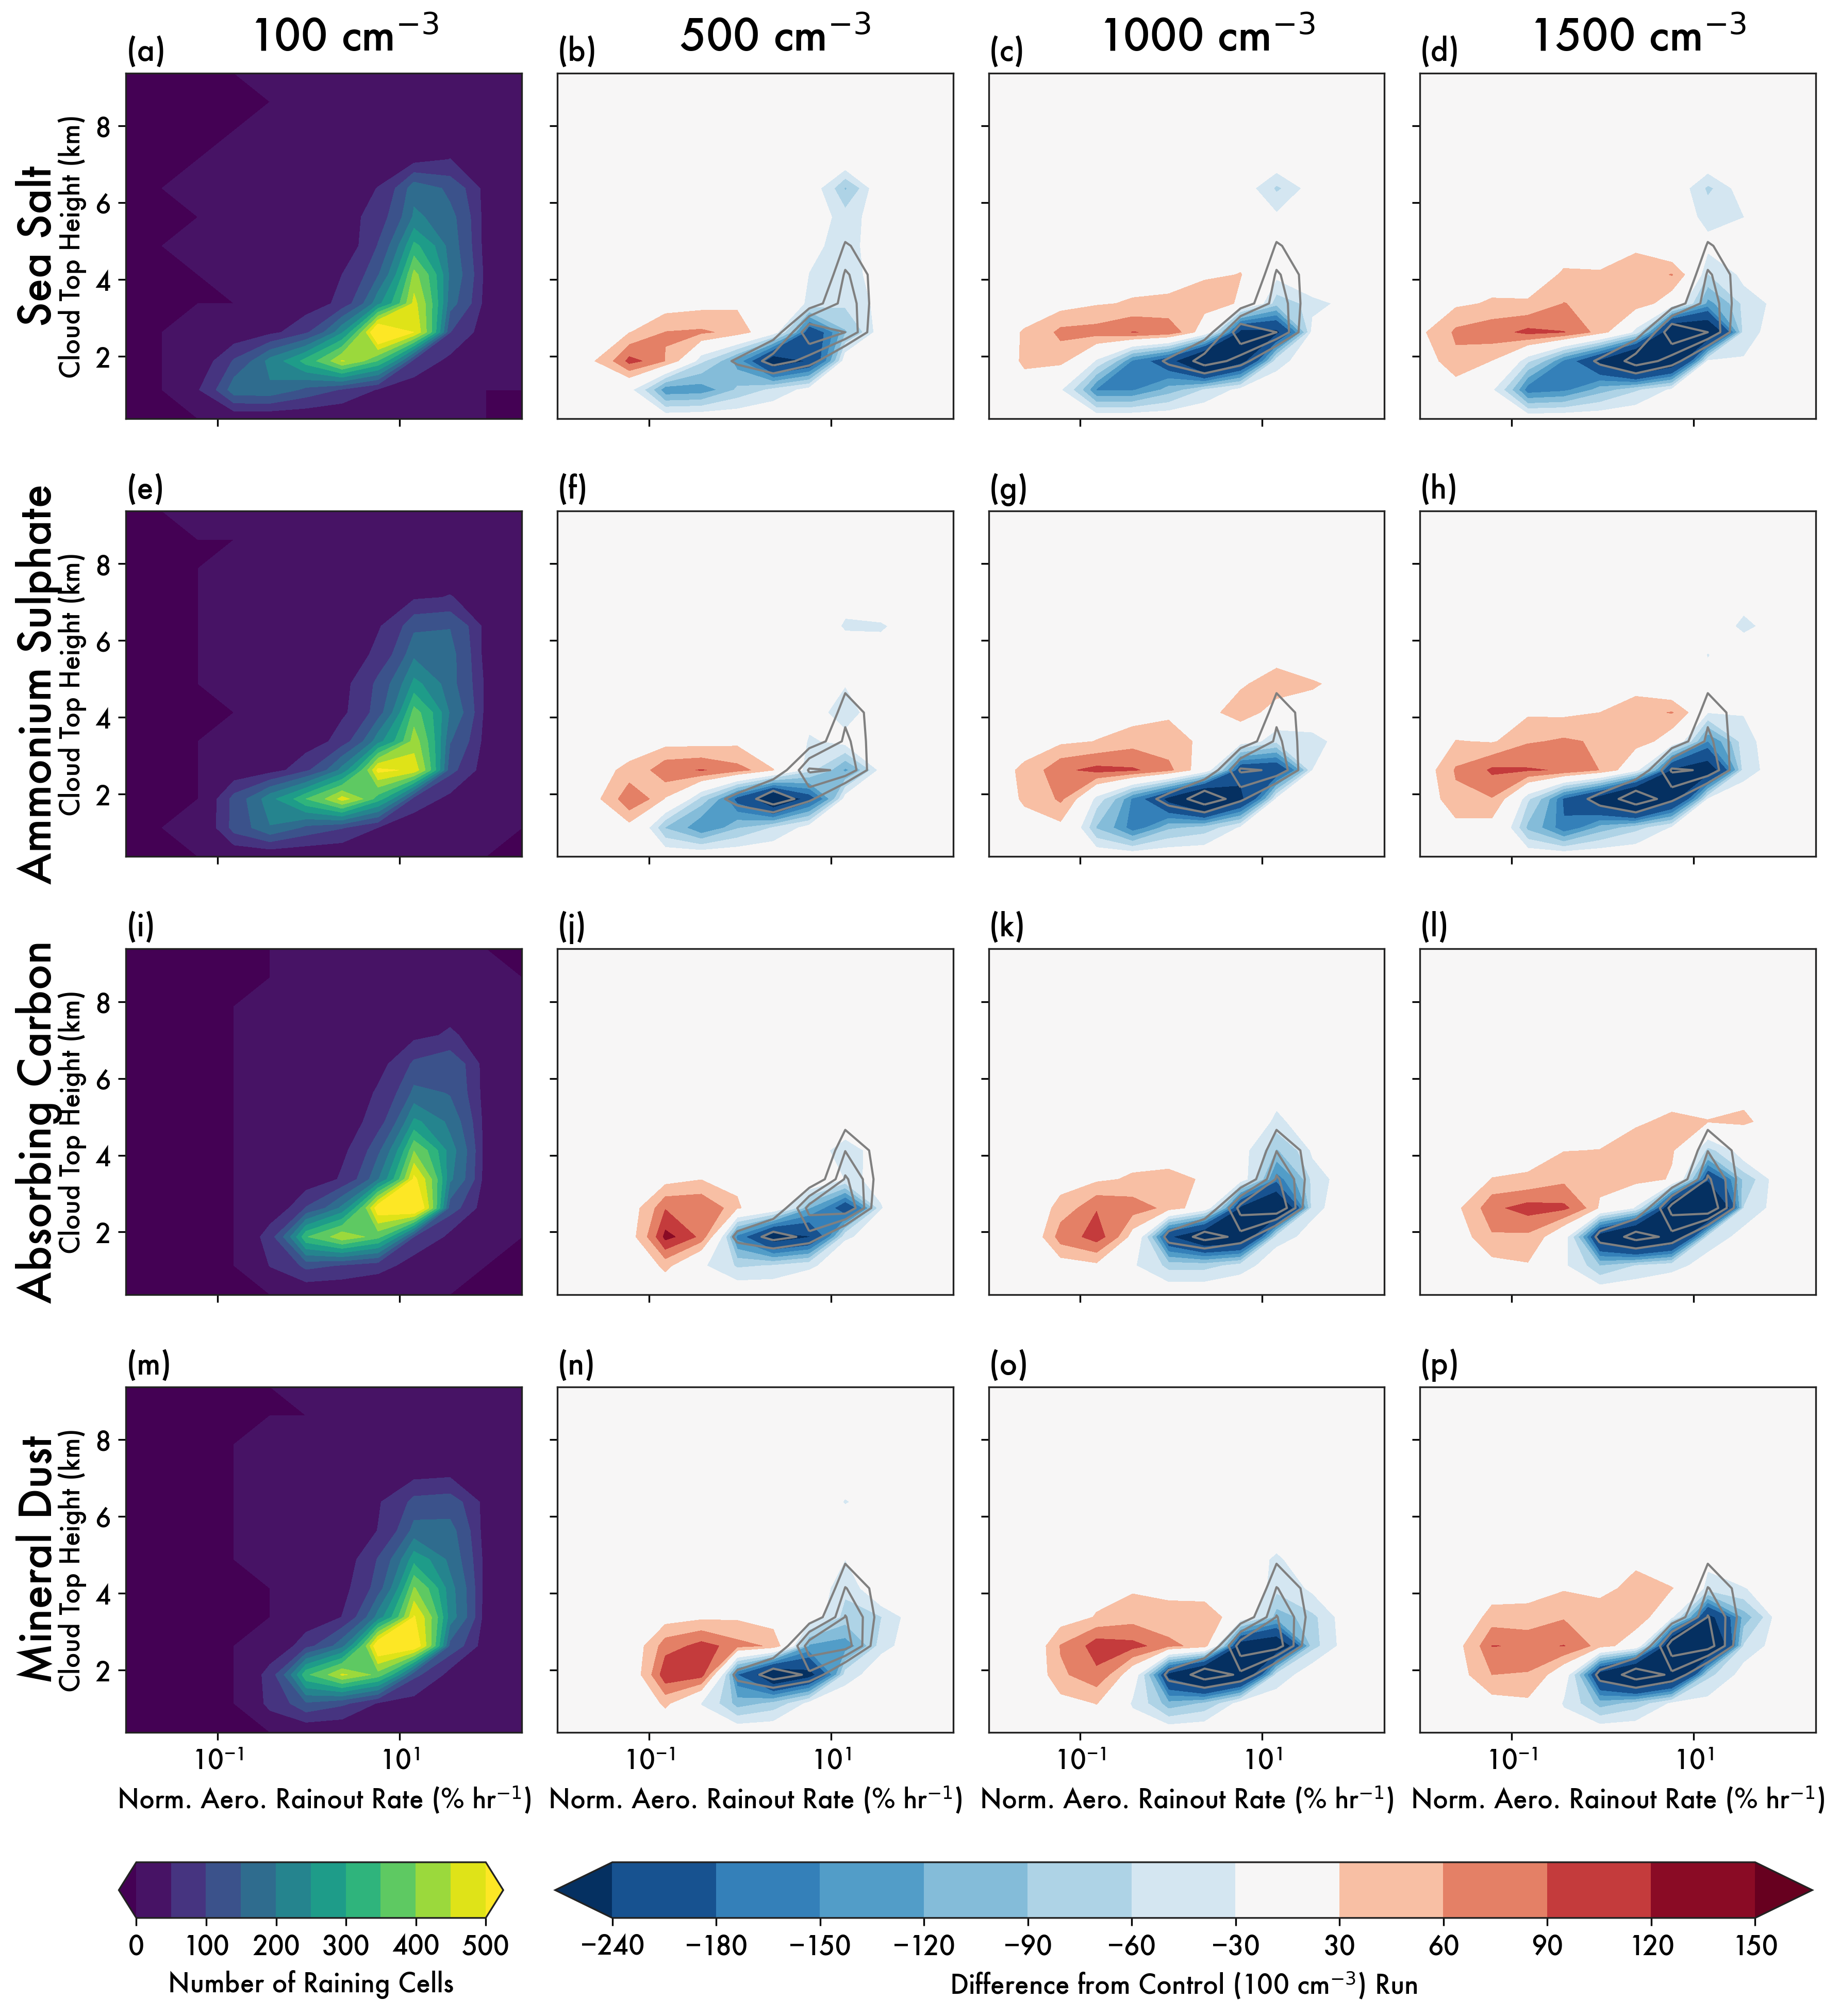

In [11]:
cthbins = np.arange(0,10,0.75)#(alt/1000)[1:80:5].reset_index()[0].values
pcprrbins = np.logspace(-2.25,2.5,13)  

min_rain = 1E-4

vers = ['salt','sulf','absc','dust']
concs = [100,500,1000,1500]

fig, axess = plt.subplots(4,4,sharex=True,sharey=True, figsize=(12,12))

for ax, ver in zip((axess.T)[0], vers):
    ax.set_ylabel('Cloud Top Height (km)')
    ax.text(-0.22, 0.5, labels.Name.loc[ver],
            ha = 'center', va = 'center',
            rotation = 90,
            fontsize = 20, 
           transform = ax.transAxes)
    
for ax in axess[-1]:
    ax.set_xlabel('Norm. Aero. Rainout Rate (% hr$^{-1}$)')
    
for ax, conc in zip(axess[0], concs):
    ax.text(0.55, 1.1, f"{conc} cm$^{{-3}}$",
           ha = 'center', va='center',
           fontsize=20,
           transform = ax.transAxes)
    ax.set_xscale('log')
    
i = 0
plt.tight_layout()
plt.subplots_adjust(hspace=0.15, wspace=0.135)

for axes, ver in zip(axess,vers):
    runs = [f"{ver}.{conc}" for conc in concs]

    for ax, run in zip(axes, runs):
        out = pd.read_pickle(f"{anaPath}{run}/tobac/full_tobac_output.pkl")
        out = out[out.cellmax_mean_pcprr>=min_rain]
        bs = pd.read_pickle(f"{anaPath}{run}/domain_byalt/unpro_aero.pkl").loc[0] #total initial aerosol mass per altitude
        bs = (bs*weight_all).sum() #total initial aerosol mass over whole domain
        bs = bs/(nx*ny*dx*dy) #initial aerosol mass in one column

        out['cellmean_mean_wtdep'] = 100* out.cellmean_mean_wtdep/bs #normalize
        out['cellmax_mean_wtdep'] = 100* out.cellmax_mean_wtdep/bs #normalize
        out = out.groupby('cell').mean()
    
        plot = np.histogram2d(out.cellmax_CTH.values, 
                              out.cellmax_mean_wtdep.values, 
                              bins = (cthbins, pcprrbins))
        out = plot[0] 
        
        if run.endswith('100'):
            c = ax.contourf((pcprrbins[1:]+pcprrbins[:-1])/2,
                            (cthbins[1:]+cthbins[:-1])/2, 
                    out, 
                    levels=np.linspace(0,500,11), 
                    extend='both')
            base = out.copy()
            
        else:
            out = out-base
            d = ax.contourf((pcprrbins[1:]+pcprrbins[:-1])/2,
                            (cthbins[1:]+cthbins[:-1])/2,
                        out,cmap='RdBu_r',
                        levels =  [-240,-180,-150,-120,-90,-60,-30,30,60,90,120,150],
                        norm = mcolors.TwoSlopeNorm(vcenter=0),
                            extend='both')
            ax.contour((pcprrbins[1:]+pcprrbins[:-1])/2,
                            (cthbins[1:]+cthbins[:-1])/2,
                       base, colors='gray',
                       levels = [300,400,500],
                      linewidths = 1)
            
        ax.set_title(f"({char[i]})", fontsize=14)
        i+=1
        
        ax.set_xlim((pcprrbins[0]+pcprrbins[1])/2, (pcprrbins[-1]+pcprrbins[-2])/2)
            
    if ver == vers[-1]:
        cax = fig.add_axes([axes[0].get_position().x0,
                    axes[0].get_position().y0-0.1, 
                    axes[0].get_position().x1 - axes[0].get_position().x0,
                    0.03])
        plt.colorbar(c, cax = cax, orientation='horizontal', label = 'Number of Raining Cells')
        
        cax = fig.add_axes([axes[1].get_position().x0,
                    axes[1].get_position().y0-0.1, 
                   axes[-1].get_position().x1 - axes[1].get_position().x0,
                           0.03])
        cbar = plt.colorbar(d,cax=cax, orientation='horizontal', 
                            label = 'Difference from Control (100 cm$^{-3}$) Run',
                            ticks =  [-240,-180,-150,-120,-90,-60,-30,30,60,90,120,150],
                           )
fig.patch.set_facecolor(bg)
plt.savefig(f"{figPath}/fig8-wetdepdist.png",dpi=300,bbox_inches='tight')
plt.show()

# Fig 9. Aerosol Type on Radiative Heating Rates

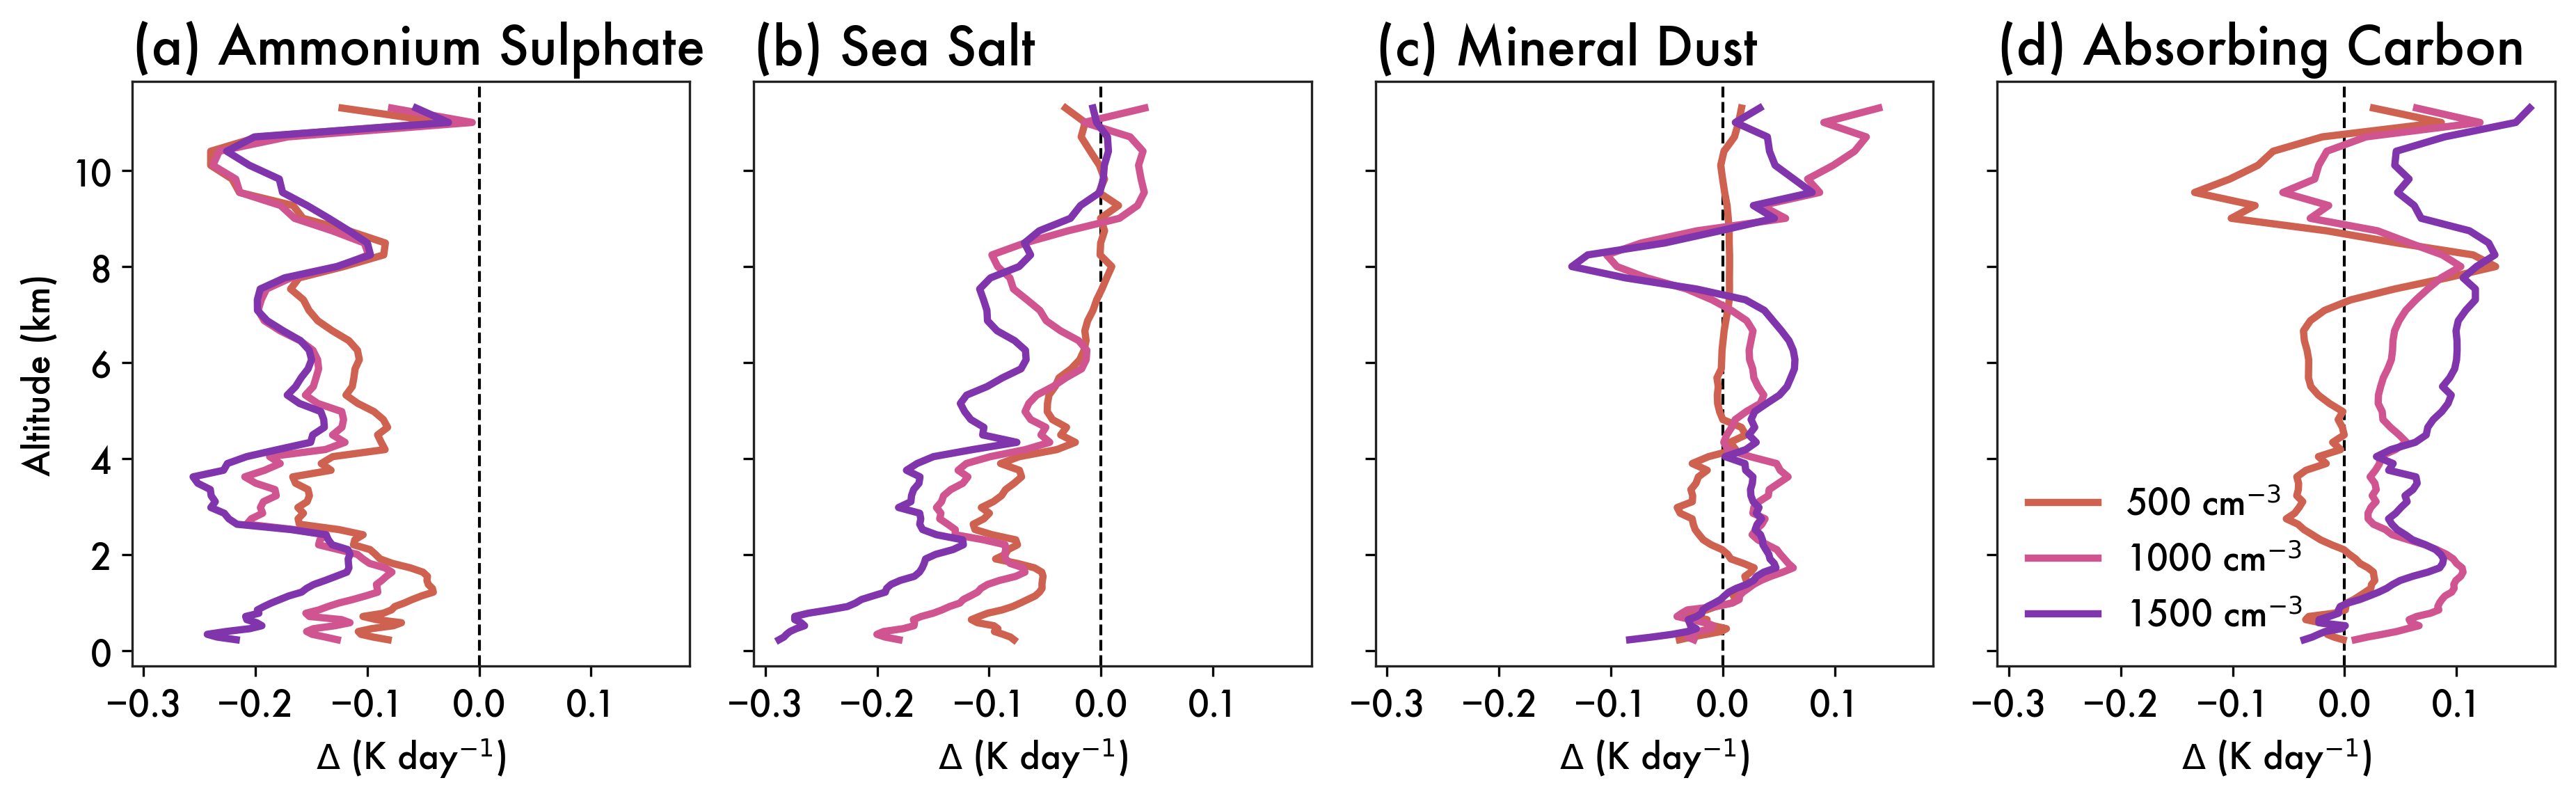

In [28]:
var = 'FTHRD'

fig, axes = plt.subplots(1,4, sharex=True,sharey=True,figsize=(12.5,4))
vers = ['sulf','salt','dust','absc']

for i, (ax, ver) in enumerate(zip(axes, vers)):
    runs = [f"{ver}.{conc}" for conc in concs]
    
    for run, col in zip(runs,cs):
        df = pd.read_pickle(f"{anaPath}{run}/domain_byalt/{var}_clrsky_mean.pkl")
        plot = df.loc[576][5:80] * 3600 * 24
        if run == runs[0]:
            base = plot
        else:
            ax.plot(plot - base,
                    alt[5:80]/1000, 
                    color=col, 
                    label =  f"{run.split('.')[-1]} cm$^{{-3}}$")
            
    ax.set_title(f"({char[i]}) {labels.loc[ver].Name}")
    ax.axvline(0, ls='--', lw=1,zorder=0)
    
    ax.set_xlabel('$\Delta$ (K day$^{-1}$)')
    
axes[0].set_ylabel('Altitude (km)')
axes[-1].legend(loc='lower left')
plt.savefig(f"{figPath}/fig9-radiativeheating.png",dpi=300,transparent=True)
plt.show()